# **Exploratory Data Analysis**
In part 1, we mainly stayed focused to generate a dataset with certain key features or standard_type (IC50). In this section we will use the generated data and to generate or to fix molecular descriptors present in the chemical structures. After successful generation, we will perform some analysis, to what we call Exploratory Data Analysis. I highly acknowledge and refer materials of Dr. Chanin Nantasenamat an Associate professor in Bioinformatics.
So Let's Move.
This Notebook is created by **Dr. Ashfaq Ahmad**

### **Install Conda and rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [2]:
import pandas as pd

### **Step 1 - Loading (Bioactivity Data) Generated in Part-1**

To upload your file, run the following cell. You will be promted to upload your datafile, already prepared and saved in CSV formate.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving P2Y1_03_bioactivity_data_curated.csv to P2Y1_03_bioactivity_data_curated.csv


In [40]:
df = pd.read_csv('P2Y1_03_bioactivity_data_curated.csv')

In [ ]:
df

In [6]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [42]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

### **Step 2 - Calculations of Lipinski Descriptors**
What are Lipinski rules or Descriptors?

A Pfizer scientist, Christopher Lipinski, designed a bunch of rules in evaluating a chemical compound for **druglikeness**. Lipinski analyzed these rules after studying vaste number of FDA-approved drugs in the formulation. In Simple terms, druglikeness is primarily based on the drug Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski rules are normally known as  **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule states,
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import essential libraries to the workspace**

In [ ]:
!pip install rdkit

In [45]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

**Now we are in a position to calculate Lipinski descriptors**

### **Step 3 - Calculation of Lipinski Descriptors**

In [46]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [47]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)

In [ ]:
df_lipinski

So far we have two dataframes, the df_lipinski and the df. We need to combine both these two frames into a single frame. If you want to see, these two frames, run the two cells below.

In [ ]:
df_lipinski

In [ ]:
df

Lets Combine

In [49]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

### **Step 4 - Convert IC50 to pIC50**
The **IC50** values are normally too much diverse therefore we need to the data to be more uniformly distributed, and for the reason we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)** or **pIC50**

Next we will use the custom function pIC50() which will accept a DataFrame as input and will output,
* Take the IC50 values from the ``standard_value`` column and converts it from nM (nanoMolar) to M (molar) concentration by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column.

Point to note: These calculations will also normalize the data and values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [51]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

In [ ]:
df_combined.standard_value.describe()

In [ ]:
-np.log10( (10**-9)* 100000000 )

In [ ]:
-np.log10( (10**-9)* 10000000000 )

In [23]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)

    return x

In [ ]:
import pandas as pd

# Normalization function
def norm_value(input_df):
    # Normalize the 'standard_value' column
    norm = (input_df['standard_value'] - input_df['standard_value'].min()) / (input_df['standard_value'].max() - input_df['standard_value'].min())
    input_df['standard_value_norm'] = norm
    x = input_df.drop('standard_value', axis=1)
    return x

# Assuming df_combined is already loaded
df_norm = norm_value(df_combined)
print(df_norm)

In [ ]:
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [ ]:
import pandas as pd

# Function to calculate pIC50 values
def pIC50(input_df):
    # Assuming we are calculating pIC50 using the normalized values
    input_df['pIC50'] = -np.log10(input_df['standard_value_norm'] * 1e-9)  # Example transformation
    return input_df

# Assuming df_norm is already created
df_final = pIC50(df_norm)
print(df_final)

In [ ]:
df_final

In [ ]:
df_final.pIC50.describe()

Now, we are in a position to save our data into CSV file

In [35]:
df_final.to_csv('P2Y1_04_bioactivity_data_3class_pIC50.csv')

### **Step 5 - Removal of the intermediate class from the whole data**
Here we are going to drop the compounds with intermediate bioactivity. We will drop them because we want to compare the active and inactive class.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

Write results to the CSV file

In [37]:
df_2class.to_csv('P2Y1_05_bioactivity_data_2class_pIC50.csv')

## **Exploratory Data Analysis OR Chemical Space Analysis through Lipinski descriptors**

### **Step 6 - Import Essential Libraries**

In [38]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Analysis of Frequency plot of the two bioactivity classes**

Text(0, 0.5, 'Frequency')

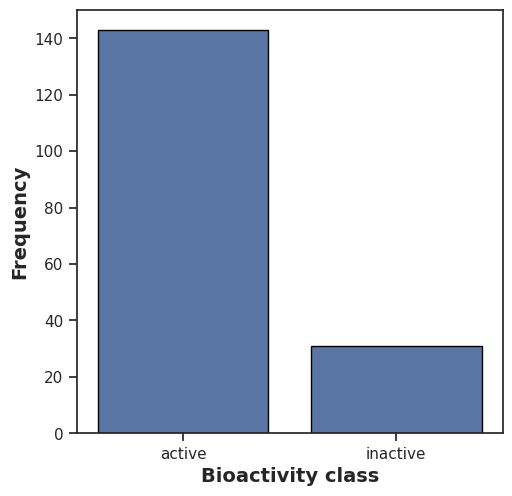

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

In [ ]:
plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of Molecular Weight (MW) versus LogP (Solubility)**

It can be seen that the 2 bioactivity classes are not taking or spanning a kind of similar chemical spaces as evident by the scatter plot of MW vs LogP.
In below function, **x** and **y** are for the legends on these axis. **data** means, data to be plotted. **hue** represents the coloring scheme, and here we are interested to be based on the bioactivity class. **size** are for the sphere size and will be proportional to the pIC50 value. sphere **edges** will be black and transperancy threshould or *alpha* of the picture is 0.7. You can adjusted if required.

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**
Lets do some calculations with Box plot

#### **pIC50 value**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_IC50.pdf')

### **Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

#### **Molecular Weight (MW)**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

#### **LogP or Solubility**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

#### **NumHDonors or H-bond Donor**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

#### **NumHAcceptors or H-bond Acceptor**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

### **Interpretation of the Statistical Results**

In the final part we have run Mannwhitney U test. The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed.

The p-value is a probability that measures the evidence against the null hypothesis. A smaller p-value provides stronger evidence against the null hypothesis.

#### **Download these results as a Zip files**

In [ ]:
! zip -r Drug_Designing_Part2.zip . -i *.csv *.pdf